In [ ]:
0pfrom keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import cv2
from keras.models import model_from_json
import numpy as np

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
import os
import zipfile
import shutil
from sklearn.model_selection import train_test_split
from collections import Counter

zip_path = "/content/archive (1).zip"
fixed_zip = "/content/dataset_project.zip"
extract_dir = "/content/dataset"
train_dir = "/content/train"
test_dir = "/content/test"

if os.path.exists(zip_path):
    if os.path.exists(fixed_zip):
        os.remove(fixed_zip)
    os.rename(zip_path, fixed_zip)
else:
    fixed_zip = zip_path.replace(" ", "_")

if not os.path.exists(extract_dir):
    if zipfile.is_zipfile(fixed_zip):
        with zipfile.ZipFile(fixed_zip, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print("✅ Extracted successfully to:", extract_dir)
    else:
        raise ValueError("❌ Not a valid ZIP file! Please re-upload a proper zip.")
else:
    print("⚠️ Extraction folder already exists. Skipping extraction.")

all_images = []
all_labels = []

for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            all_images.append(os.path.join(root, file))
            all_labels.append(os.path.basename(os.path.dirname(os.path.join(root, file))))

if len(all_images) == 0:
    raise ValueError("❌ No images found! Please check your zip structure.")

print(f"📸 Total images found: {len(all_images)}")
print("✅ Unique emotion classes:", set(all_labels))
print("🗂 Image count per class:", Counter(all_labels))

label_counts = Counter(all_labels)
min_class_count = min(label_counts.values())

stratify_labels = all_labels if min_class_count > 1 else None
if stratify_labels is None:
    print("⚠️ Some classes have only 1 image. Splitting without stratify.")

train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=stratify_labels
)

print(f"🟢 Training images: {len(train_images)}, Testing images: {len(test_images)}")

def save_images(image_list, label_list, out_dir):
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)
    os.makedirs(out_dir, exist_ok=True)

    for img_path, label in zip(image_list, label_list):
        class_dir = os.path.join(out_dir, label)
        os.makedirs(class_dir, exist_ok=True)
        if os.path.exists(img_path):
            shutil.copy(img_path, os.path.join(class_dir, os.path.basename(img_path)))
        else:
            print("⚠️ Missing image, skipped:", img_path)

save_images(train_images, train_labels, train_dir)
save_images(test_images, test_labels, test_dir)

print("✅ Train/Test split completed.")
print("📂 Training folder:", train_dir)
print("📂 Testing folder:", test_dir)


⚠️ Extraction folder already exists. Skipping extraction.
📸 Total images found: 152
✅ Unique emotion classes: {'0', '16', '17', '10', '15', '14', '6', '4', '18', '1', '13', '2', '7', '5', '11', '9', '12', '8', '3'}
🗂 Image count per class: Counter({'4': 8, '17': 8, '8': 8, '0': 8, '13': 8, '2': 8, '3': 8, '12': 8, '9': 8, '7': 8, '10': 8, '14': 8, '11': 8, '18': 8, '5': 8, '16': 8, '6': 8, '15': 8, '1': 8})
🟢 Training images: 121, Testing images: 31
✅ Train/Test split completed.
📂 Training folder: /content/train
📂 Testing folder: /content/test


In [ ]:
train_generator = train_data_gen.flow_from_directory(
    '/content/train',
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical')

Found 121 images belonging to 19 classes.


In [ ]:
validation_generator = validation_data_gen.flow_from_directory(
        '/content/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 31 images belonging to 19 classes.


In [ ]:
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                         input_shape=(48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))

emotion_model.add(Dense(train_generator.num_classes, activation='softmax'))

emotion_model.summary()

cv2.ocl.setUseOpenCL(False)

initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100000,
                               decay_rate=0.96)

optimizer = Adam(learning_rate=lr_schedule)

emotion_model.compile(loss='categorical_crossentropy', optimizer=optimizer,
                      metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 19)             │        19,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,357,907 (8.99 MB)

 Trainable params: 2,357,907 (8.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
emotion_model_info = emotion_model.fit(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
  2/448 ━━━━━━━━━━━━━━━━━━━━ 1:12:08 10s/step - accuracy: 0.1199 - loss: 2.9377

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


448/448 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.0993 - loss: 2.9429 - val_accuracy: 0.0968 - val_loss: 2.9416
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.0661 - loss: 2.9311 - val_accuracy: 0.1290 - val_loss: 2.9393
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.0910 - loss: 2.9448 - val_accuracy: 0.1290 - val_loss: 2.9369
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.1074 - loss: 2.9268 - val_accuracy: 0.0968 - val_loss: 2.9338
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.1075 - loss: 2.9136 - val_accuracy: 0.0645 - val_loss: 2.9316
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.0992 - loss: 2.9181 - val_accuracy: 0.0968 - val_loss: 2.9293
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.1239 - loss: 2.9055 - val_accuracy: 0.1935 - val_loss: 2.9267
Epoch 8/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.1239 - loss: 2.9143 - val_accurac

In [ ]:
emotion_model.evaluate(validation_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6129 - loss: 2.3156


[2.3155736923217773, 0.6129032373428345]

In [ ]:
accuracy = emotion_model_info.history['accuracy']
val_accuracy = emotion_model_info.history['val_accuracy']
loss = emotion_model_info.history['loss']
val_loss = emotion_model_info.history['val_loss']

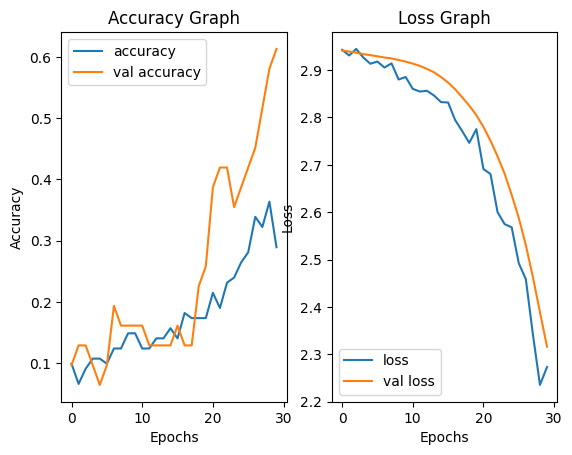

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='val accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model_json = emotion_model.to_json()
with open("emotion_model.json", "w") as json_file:
    json_file.write(model_json)
emotion_model.save_weights('emotion_model.weights.h5')

In [ ]:
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fearful",
                3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised",
                7: "Class_7", 8: "Class_8", 9: "Class_9", 10: "Class_10",
                11: "Class_11", 12: "Class_12", 13: "Class_13", 14: "Class_14",
                15: "Class_15", 16: "Class_16", 17: "Class_17", 18: "Class_18"}

json_file = open('emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)


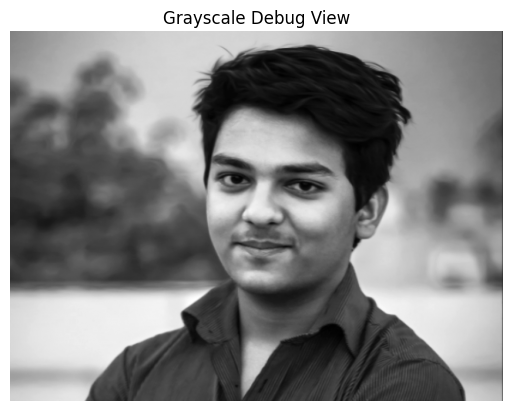

Faces detected: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


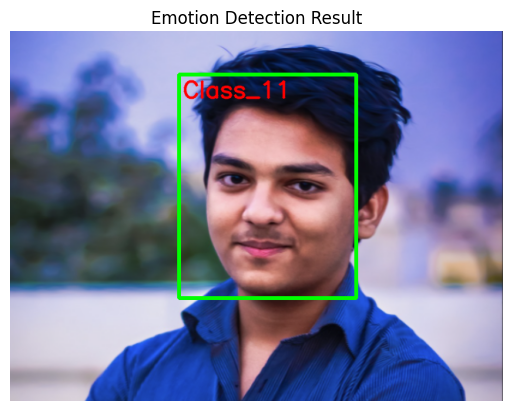

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
frame = cv2.imread('/content/boy pic.png')

if frame is None:
    print("❌ Error: Could not load image. Check the file path.")
else:

    frame = cv2.resize(frame, (640, 480))
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray_frame, cmap='gray')
    plt.axis('off')
    plt.title("Grayscale Debug View")
    plt.show()

    face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    num_faces = face_detector.detectMultiScale(
        gray_frame,
        scaleFactor=1.1,
        minNeighbors=3,
        minSize=(30, 30)
    )

    print(f"Faces detected: {len(num_faces)}")
    for (x, y, w, h) in num_faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (0, 255, 0), 4)

        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = cv2.resize(roi_gray_frame, (48, 48))
        cropped_img = np.expand_dims(np.expand_dims(cropped_img, -1), 0)

        emotion_prediction = emotion_model.predict(cropped_img)
        maxindex = int(np.argmax(emotion_prediction))
        emotion_text = emotion_dict[maxindex]

        cv2.putText(frame, emotion_text, (x+5, y-20),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Emotion Detection Result")
    plt.show()

